Training model...


C:\Users\VIVEK\AppData\Local\Temp\ipykernel_11232\1496081218.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time and Date'] = pd.to_datetime(df['Time and Date'])


Epoch [1/100], Train Loss: 1.0045, Test Loss: 0.8756
Epoch [11/100], Train Loss: 0.9917, Test Loss: 0.8635
Epoch [21/100], Train Loss: 0.9503, Test Loss: 0.8238
Epoch [31/100], Train Loss: 0.8613, Test Loss: 0.7450
Epoch [41/100], Train Loss: 0.7392, Test Loss: 0.6324
Epoch [51/100], Train Loss: 0.6026, Test Loss: 0.5137
Epoch [61/100], Train Loss: 0.4810, Test Loss: 0.4091
Epoch [71/100], Train Loss: 0.3848, Test Loss: 0.3274
Epoch [81/100], Train Loss: 0.3163, Test Loss: 0.2699
Epoch [91/100], Train Loss: 0.2702, Test Loss: 0.2321


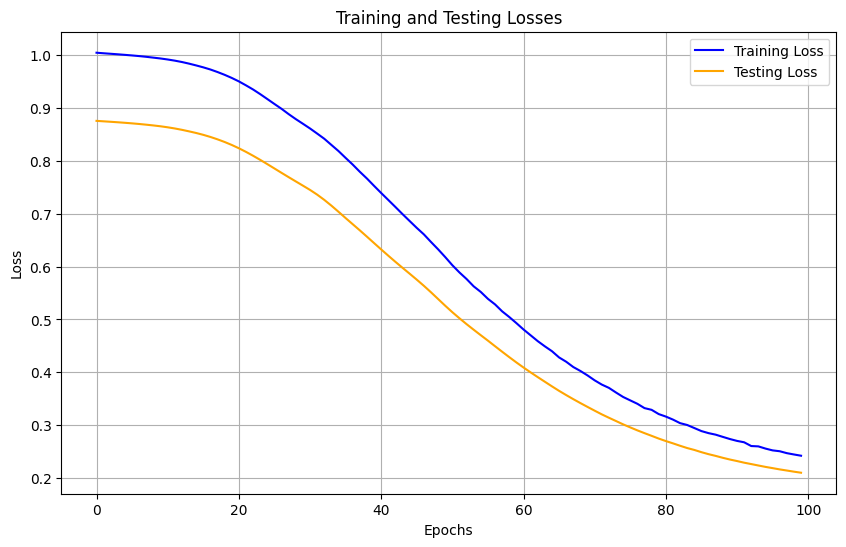

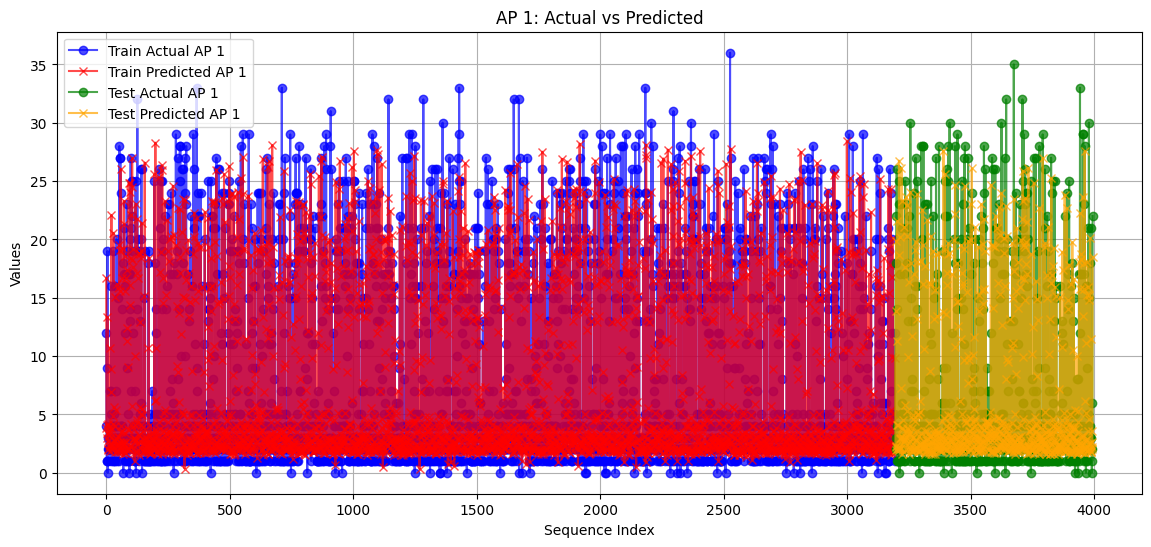

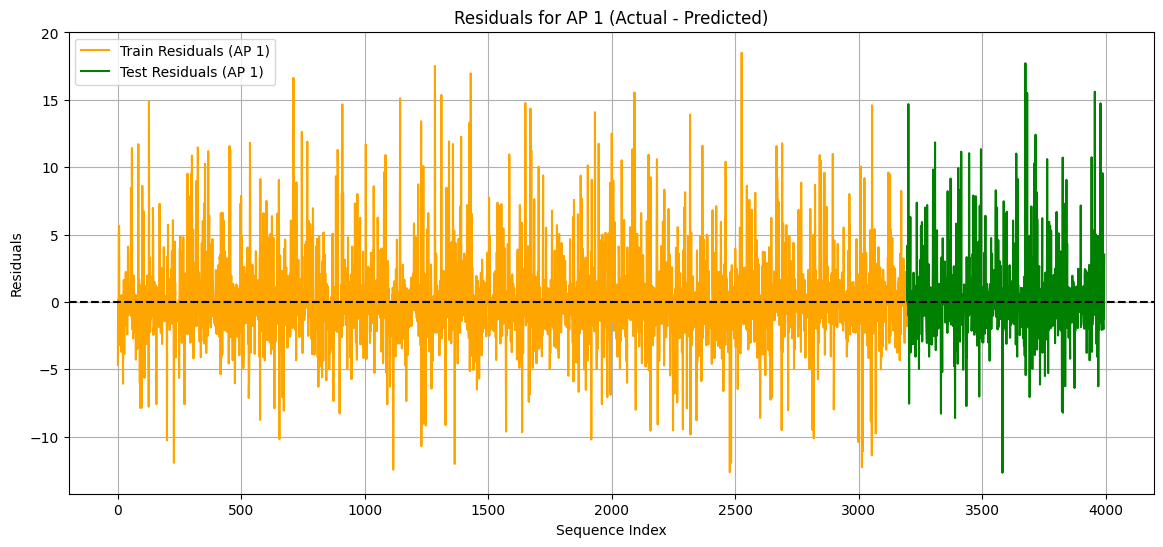


Generating and evaluating forecasts...
Intial sequence shape : torch.Size([1, 5, 96])


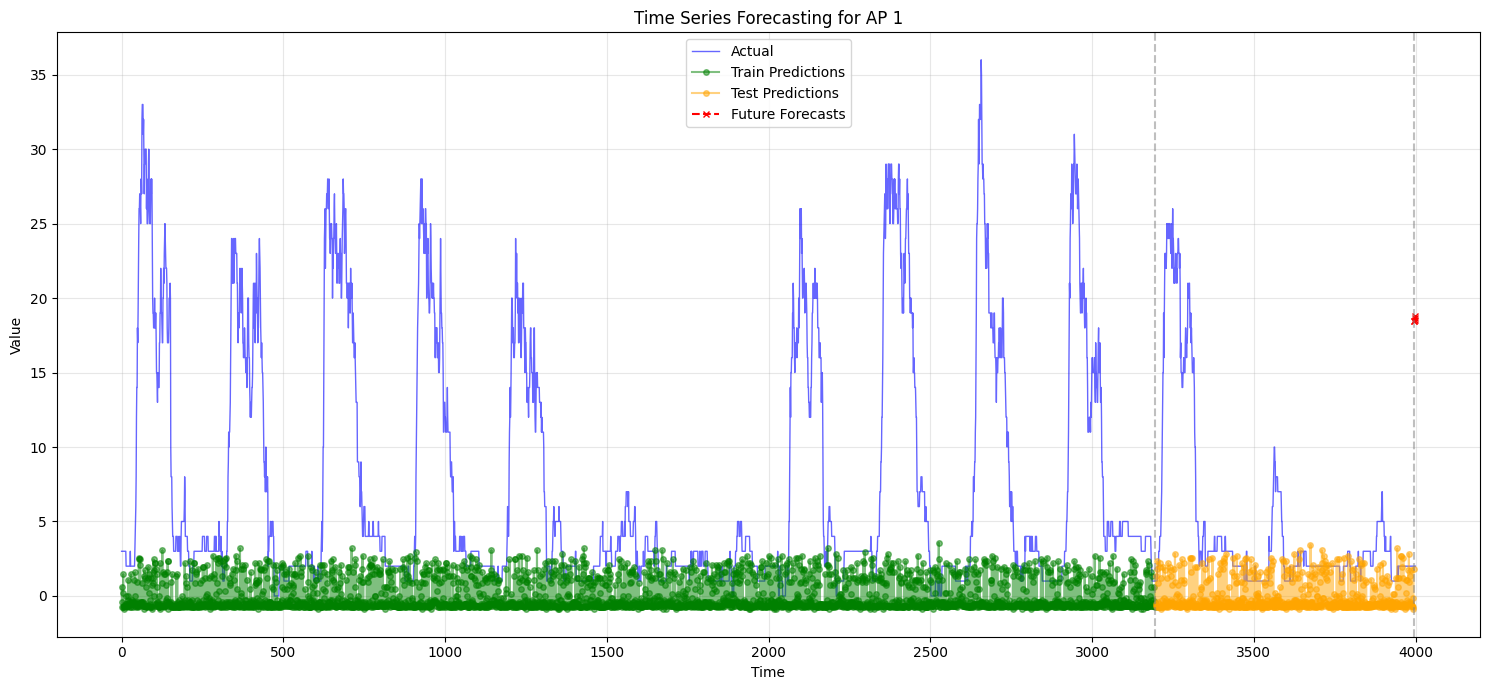

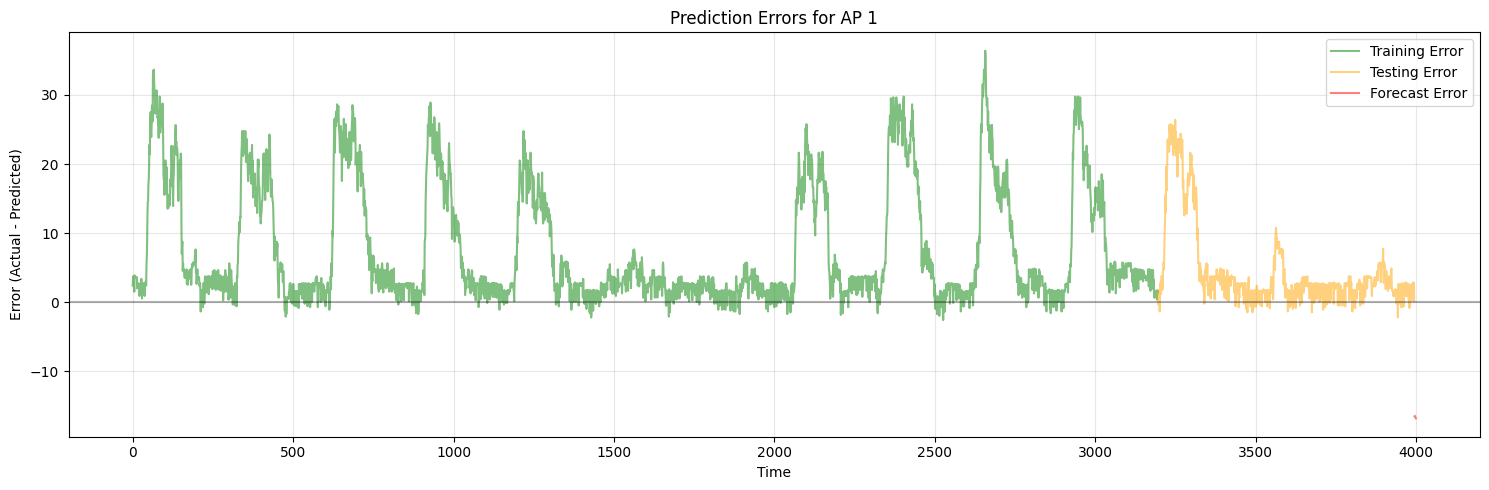

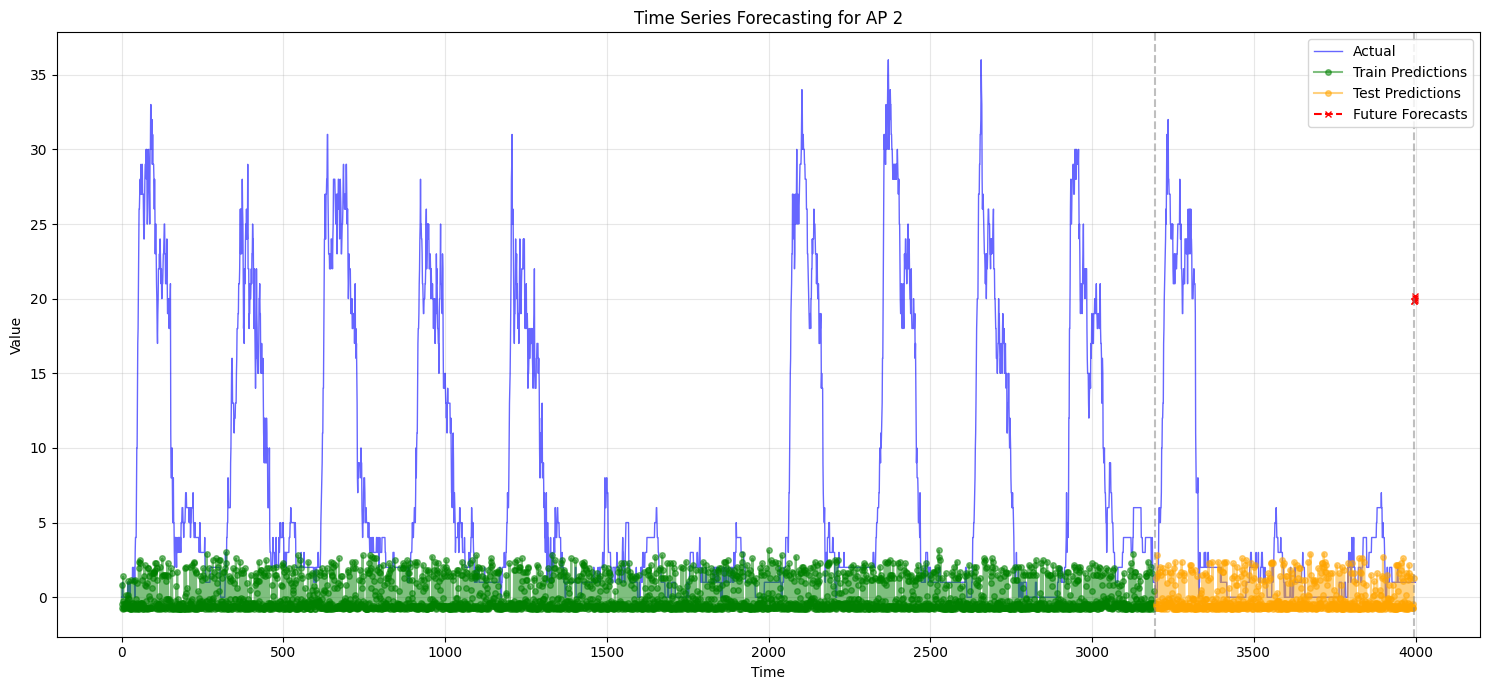

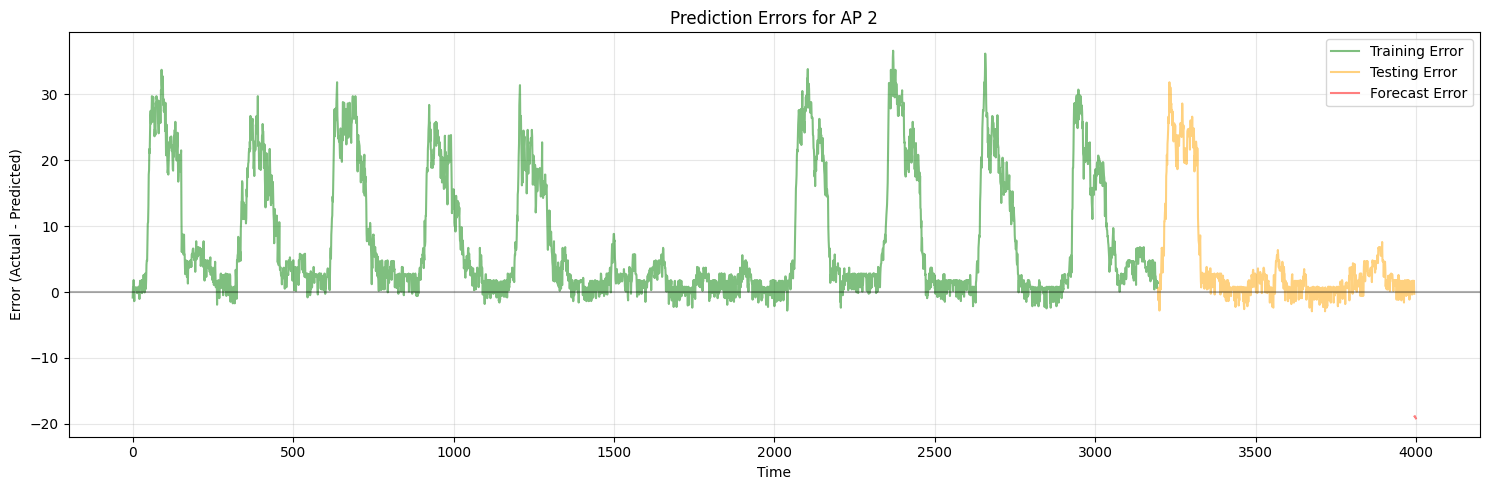

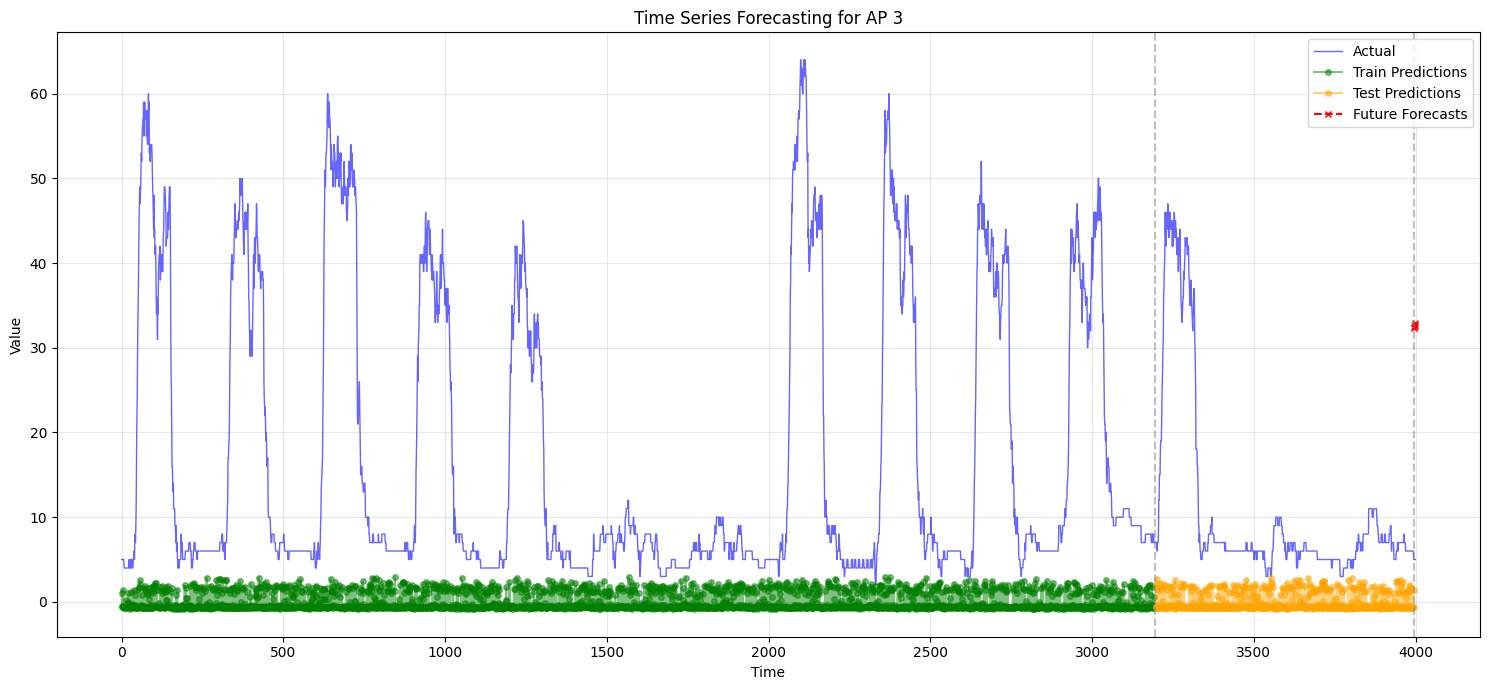

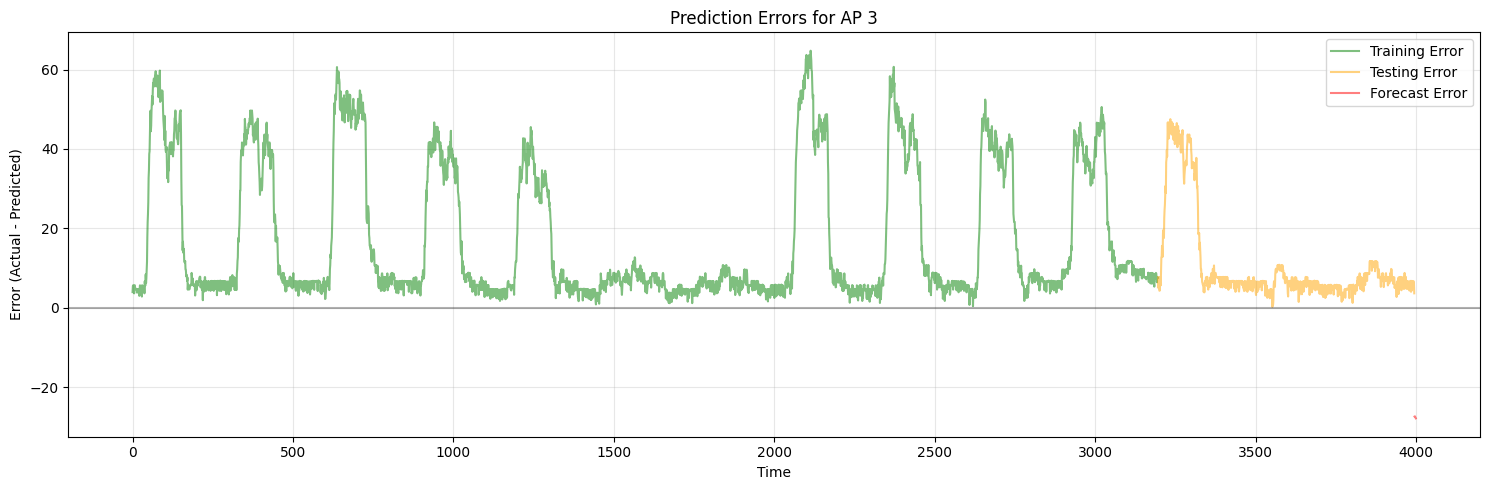

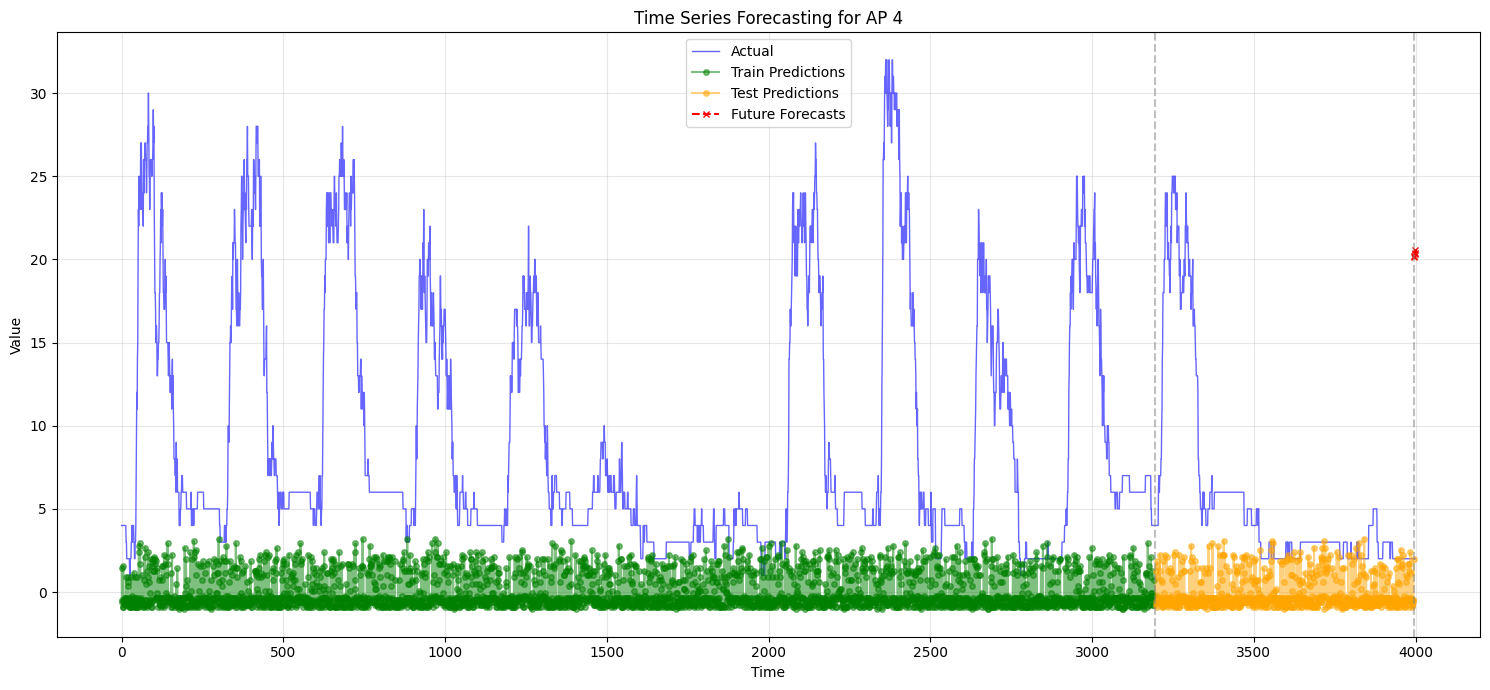

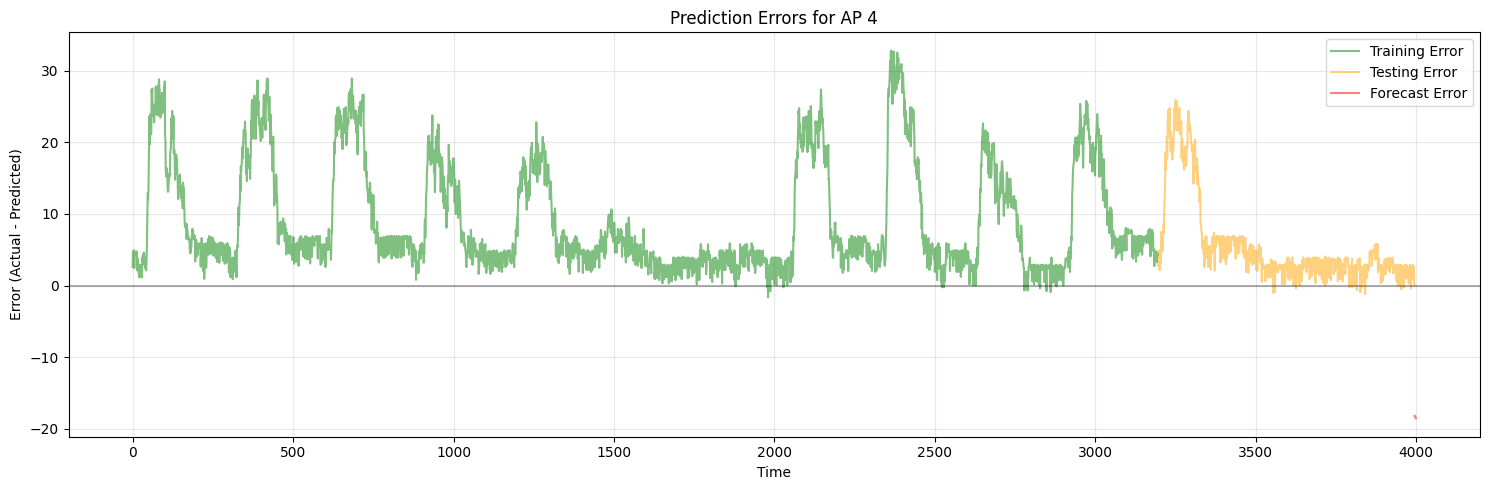

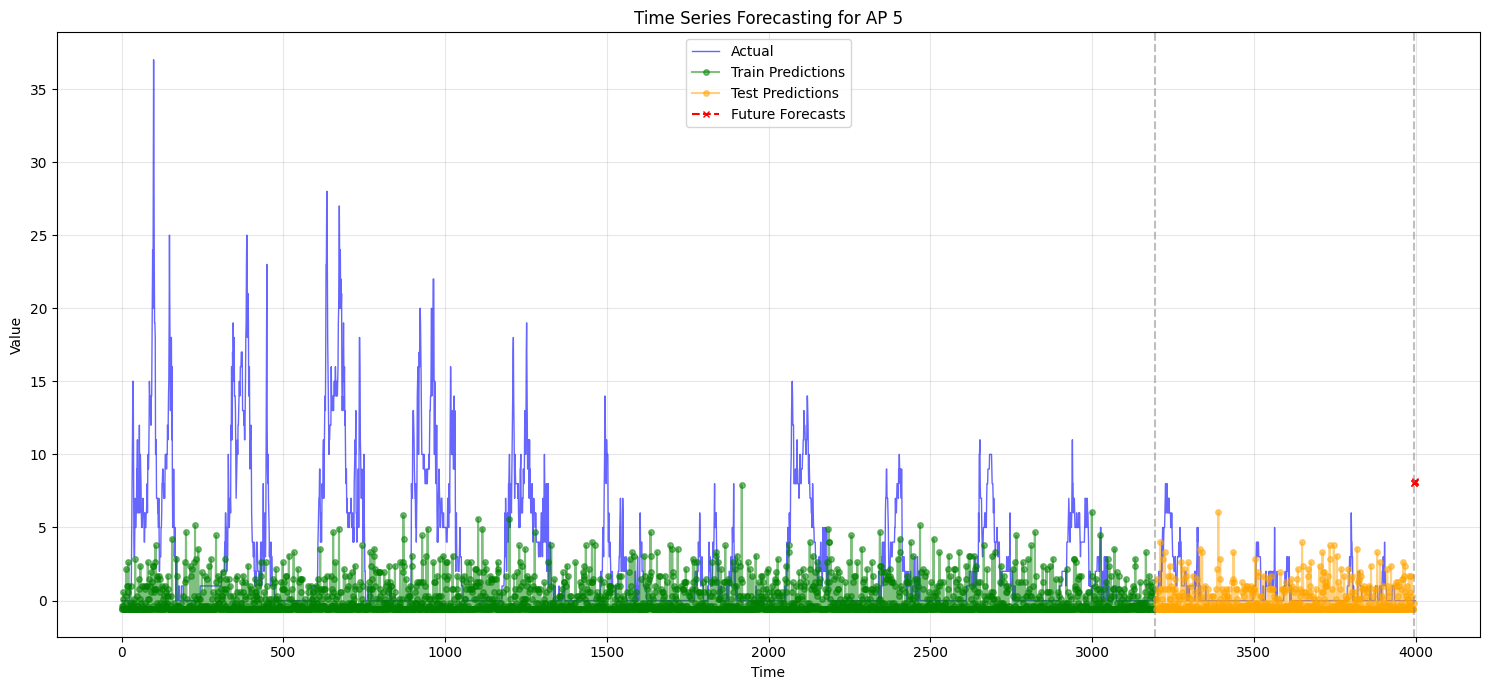

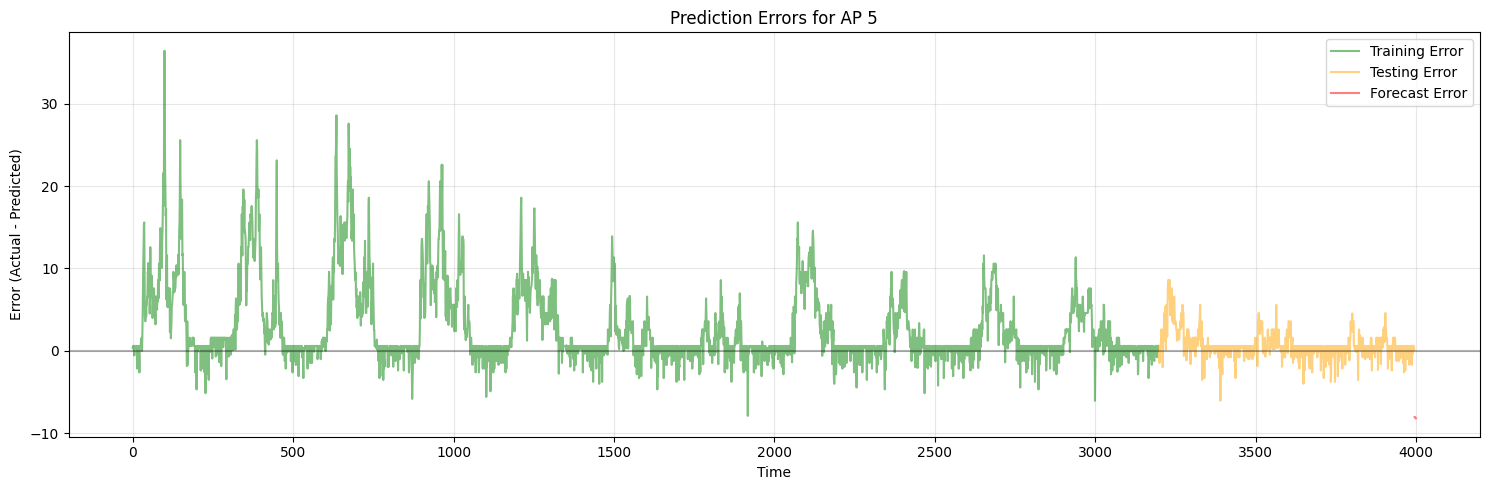


Training Metrics:

AP 1:
RMSE: 11.4880
MAE: 7.8850
R2: -0.8748

AP 2:
RMSE: 12.3567
MAE: 8.2164
R2: -0.7578

AP 3:
RMSE: 24.4969
MAE: 17.5633
R2: -1.0591

AP 4:
RMSE: 11.9223
MAE: 9.2910
R2: -1.5697

AP 5:
RMSE: 5.6942
MAE: 3.4624
R2: -0.4630

AP 6:
RMSE: 15.1187
MAE: 11.2352
R2: -1.2486

AP 7:
RMSE: 11.3617
MAE: 7.9390
R2: -0.9374

AP 8:
RMSE: 16.0654
MAE: 12.3057
R2: -1.4294

AP 9:
RMSE: 12.7007
MAE: 8.4846
R2: -0.7675

AP 11:
RMSE: 6.9818
MAE: 4.4577
R2: -0.5496

AP 12:
RMSE: 11.9060
MAE: 8.2931
R2: -0.8951

AP 13:
RMSE: 17.7817
MAE: 11.7699
R2: -0.7754

AP 14:
RMSE: 25.5255
MAE: 18.3103
R2: -1.0612

AP 15:
RMSE: 15.7280
MAE: 12.1409
R2: -1.4905

AP 16:
RMSE: 7.4665
MAE: 5.9292
R2: -1.7876

AP 17:
RMSE: 12.7230
MAE: 9.5351
R2: -1.2962

AP 18:
RMSE: 15.0288
MAE: 9.8779
R2: -0.7338

AP 19:
RMSE: 8.8101
MAE: 5.9837
R2: -0.8028

AP 20:
RMSE: 10.0118
MAE: 6.8443
R2: -0.8547

AP 21:
RMSE: 2.1688
MAE: 1.5876
R2: -0.9524

AP 22:
RMSE: 17.7245
MAE: 13.2066
R2: -1.2536

AP 23:
RMSE: 11.4881


In [1]:
# %%
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import wandb

class AdvancedTemporalGraphNetwork(nn.Module):
    def __init__(self, num_features, hidden_channels, num_nodes, dropout):
        super(AdvancedTemporalGraphNetwork, self).__init__()
        self.init_params = {
            'num_features': num_features,
            'hidden_channels': hidden_channels,
            'num_nodes': num_nodes,
            'dropout': dropout
        }
        self.feature_reducer = nn.Linear(num_features, hidden_channels)
        self.graph_conv1 = pyg_nn.SAGEConv(hidden_channels, hidden_channels)
        self.graph_conv2 = pyg_nn.SAGEConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=dropout)
        self.temporal_lstm = nn.LSTM(
            input_size=hidden_channels,
            hidden_size=hidden_channels, 
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        self.temporal_attention = nn.MultiheadAttention(
            embed_dim=hidden_channels, 
            num_heads=2, 
            batch_first=True,
            dropout=dropout
        )
        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_channels//2, num_features)
        )

    def forward(self, x, edge_index, time_sequence):
        num_features = self.init_params['num_features']
        num_nodes = self.init_params['num_nodes']
        
        if x is None:
            x = torch.randn(num_nodes, num_features, device=edge_index.device)
        x = x.float()
        
        time_sequence = time_sequence.float()
        
        reduced_features = self.feature_reducer(x)
        spatial_features = F.relu(self.graph_conv1(reduced_features, edge_index))
        spatial_features = F.relu(self.graph_conv2(spatial_features, edge_index))
        
        time_sequence_reduced = self.feature_reducer(time_sequence)
        lstm_out, _ = self.temporal_lstm(time_sequence_reduced)
        attn_out, _ = self.temporal_attention(lstm_out, lstm_out, lstm_out)
        
        predictions = self.prediction_head(attn_out[:, -1, :])
        return predictions

    def get_init_params(self):
        return self.init_params

def preprocess_timeseries_data(df, max_features=194):
    df['Time and Date'] = pd.to_datetime(df['Time and Date'])
    features_columns = [col for col in df.columns if col.startswith('AP ') and int(col.split()[1]) <= max_features]
    df_processed = df[['Time and Date'] + features_columns].copy()
    df_processed = df_processed.dropna()
    df_processed.loc[:,'hour'] = df_processed['Time and Date'].dt.hour
    df_processed.loc[:,'minute'] = df_processed['Time and Date'].dt.minute
    df_processed.loc[:,'day_of_week'] = df_processed['Time and Date'].dt.dayofweek
    features = df_processed[features_columns]
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features, scaler, df_processed

def create_sequence_data(features, sequence_length=5, test_size=0.2, random_state=42):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(features[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return (
        torch.tensor(X_train, dtype=torch.float), 
        torch.tensor(y_train, dtype=torch.float),
        torch.tensor(X_test, dtype=torch.float), 
        torch.tensor(y_test, dtype=torch.float)
    )

def create_graph_edges(num_nodes, k=5):
    edges = []
    for i in range(num_nodes):
        for j in range(max(0, i-k), min(num_nodes, i+k+1)):
            if i != j:
                edges.append([i, j])
    return torch.tensor(edges).t().contiguous()

def train_advanced_temporal_graph_model(df, config=None, num_plots=1):
    if config is None:
        config = {
            'hidden_channels': 32,
            'dropout': 0.2,
            'lr': 0.001,
            'epochs': 100
        }
    
    features, scaler, df_processed = preprocess_timeseries_data(df)
    X_train, y_train, X_test, y_test = create_sequence_data(features)
    edge_index = create_graph_edges(features.shape[1])
    
    model = AdvancedTemporalGraphNetwork(
        num_features=features.shape[1], 
        hidden_channels=config['hidden_channels'], 
        num_nodes=features.shape[1],
        dropout=config['dropout']
    )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    train_losses, test_losses = [], []
    
    for epoch in range(config['epochs']):
        model.train()
        optimizer.zero_grad()
        
        train_predictions = model(None, edge_index, X_train)
        train_loss = criterion(train_predictions, y_train)
        
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_predictions = model(None, edge_index, X_test)
            test_loss = criterion(test_predictions, y_test)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{config["epochs"]}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Testing Loss', color='orange')
    plt.title('Training and Testing Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    train_actual = scaler.inverse_transform(y_train.numpy())
    test_actual = scaler.inverse_transform(y_test.numpy())
    train_preds = scaler.inverse_transform(train_predictions.detach().numpy())
    test_preds = scaler.inverse_transform(test_predictions.detach().numpy())
    
    # Get original time series for plotting
    features_columns = [col for col in df.columns if col.startswith('AP ') and int(col.split()[1]) <= features.shape[1]]
    train_size = X_train.shape[0]
    
    # Actual vs Predicted Plots
    for i in range(min(num_plots, features.shape[1])):
        plt.figure(figsize=(14, 6))
        plt.plot(range(train_size), train_actual[:, i], 
                 label=f"Train Actual {features_columns[i]}", color="blue", marker = 'o',alpha=0.7)
        plt.plot(range(train_size), train_preds[:, i], 
                 label=f"Train Predicted {features_columns[i]}", color="red", marker = 'x', alpha = 0.7)
        plt.plot(range(train_size, train_size + len(test_actual)), test_actual[:, i], 
                 label=f"Test Actual {features_columns[i]}", color="green", marker = 'o' ,alpha=0.7)
        plt.plot(range(train_size, train_size + len(test_preds)), test_preds[:, i], 
                 label=f"Test Predicted {features_columns[i]}", color="orange", marker = 'x', alpha = 0.7)
        plt.title(f"{features_columns[i]}: Actual vs Predicted")
        plt.xlabel("Sequence Index")
        plt.ylabel("Values")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        # Residuals Plot
        train_residuals = train_actual[:, i] - train_preds[:, i]
        test_residuals = test_actual[:, i] - test_preds[:, i]
        plt.figure(figsize=(14, 6))
        plt.plot(range(train_size), train_residuals, 
                 label=f"Train Residuals ({features_columns[i]})", color="orange")
        plt.plot(range(train_size, train_size + len(test_residuals)), test_residuals, 
                 label=f"Test Residuals ({features_columns[i]})", color="green")
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel("Sequence Index")
        plt.ylabel("Residuals")
        plt.title(f"Residuals for {features_columns[i]} (Actual - Predicted)")
        plt.legend()
        plt.grid(True)
        plt.show()
    return model, (X_train, y_train), (X_test, y_test), scaler

def generate_future_forecasts(model, initial_sequence, edge_index, num_steps, scaler, feature_names):
    model.eval()
    forecasts = []
    current_sequence = initial_sequence.clone()
    sequence_length = current_sequence.shape[1]
    num_features = current_sequence.shape[2]
    print(f"Intial sequence shape : {current_sequence.shape}")

    with torch.no_grad():
        for _ in range(num_steps):
            next_step = model(None, edge_index, current_sequence)

            next_step = next_step.view(1, 1, -1)
            if next_step.shape[-1] != num_features:
                raise ValueError("Feature dimension mismatch. Expected {num_features}, got {next_step.shape[-1]}")
            
            current_sequence = torch.cat([
                current_sequence[:, 1:, :],
                next_step
            ], dim=1)
            if current_sequence.shape != (1, sequence_length, num_features):
                raise ValueError(f"Sequence shape mismatch. Expected {(1, sequence_length, num_features)}, got {current_sequence.shape}")
            forecasts.append(next_step.squeeze().numpy())

    
    forecasts = np.vstack(forecasts)
    forecasts_original = scaler.inverse_transform(forecasts)
    return forecasts_original

def plot_forecasts_with_actual(df_actual, train_preds, test_preds, future_forecasts, 
                             train_indices, test_indices, future_indices, feature_names, num_features=5):
    if torch.is_tensor(train_preds):
        train_preds = train_preds.detach().numpy()
    if torch.is_tensor(test_preds):
        test_preds = test_preds.detach().numpy()
    
    
    num_features = min(num_features, len(feature_names))
    
    for i in range(num_features):
        feature = feature_names[i]
        
        plt.figure(figsize=(15, 7))
        plt.plot(df_actual.index, df_actual[feature], 
                label='Actual', color='blue', alpha=0.6, linewidth=1)
        plt.plot(train_indices, train_preds[:, i], 
                label='Train Predictions', color='green', 
                marker='o', markersize=4, alpha=0.5)
        plt.plot(test_indices, test_preds[:, i], 
                label='Test Predictions', color='orange', 
                marker='o', markersize=4, alpha=0.5)
        plt.plot(future_indices, future_forecasts[:, i], 
                label='Future Forecasts', color='red', 
                marker='x', markersize=4, linestyle='--')
        
        plt.title(f'Time Series Forecasting for {feature}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axvline(x=train_indices[-1], color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=test_indices[-1], color='gray', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(15, 5))
        train_errors = df_actual[feature].iloc[train_indices] - train_preds[:, i]
        plt.plot(train_indices, train_errors, 
                label='Training Error', color='green', alpha=0.5)
        
        test_errors = df_actual[feature].iloc[test_indices] - test_preds[:, i]
        plt.plot(test_indices, test_errors, 
                label='Testing Error', color='orange', alpha=0.5)
        
        future_actual = df_actual[feature].iloc[future_indices]
        if len(future_actual) > 0:
            future_errors = future_actual - future_forecasts[:len(future_actual), i]
            plt.plot(future_indices[:len(future_actual)], future_errors,
                    label='Forecast Error', color='red', alpha=0.5)
        
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title(f'Prediction Errors for {feature}')
        plt.xlabel('Time')
        plt.ylabel('Error (Actual - Predicted)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def evaluate_forecasts(df_actual, predictions, feature_names, start_idx, prefix=""):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    metrics = {}
    
    for i, feature in enumerate(feature_names):
        actual = df_actual[feature].iloc[start_idx:start_idx + len(predictions)]
        pred = predictions[:, i]
        
        if len(actual) > 0:
            metrics[feature] = {
                'RMSE': np.sqrt(mean_squared_error(actual, pred)),
                'MAE': mean_absolute_error(actual, pred),
                'R2': r2_score(actual, pred)
            }
    
    if metrics:
        print(f"\n{prefix} Metrics:")
        for feature, feature_metrics in metrics.items():
            print(f"\n{feature}:")
            for metric_name, value in feature_metrics.items():
                print(f"{metric_name}: {value:.4f}")
    
    return metrics

def forecast_and_evaluate(model, df, train_data, test_data, config):
    feature_names = [col for col in df.columns if col.startswith('AP ')]
    sequence_length = train_data[0].shape[1]
    num_future_steps = min(1000, len(df) - len(train_data[0]) - len(test_data[0]))
    
    initial_sequence = test_data[0][-1:]
    edge_index = create_graph_edges(len(feature_names))
    
    future_forecasts = generate_future_forecasts(
        model, initial_sequence, edge_index, 
        num_future_steps, config['scaler'], feature_names
    )
    
    train_indices = range(len(train_data[1]))
    test_indices = range(len(train_data[1]), len(train_data[1]) + len(test_data[1]))
    future_indices = range(test_indices[-1] + 1, test_indices[-1] + 1 + num_future_steps)
    
    plot_forecasts_with_actual(
        df[feature_names], train_data[1], test_data[1], future_forecasts,
        train_indices, test_indices, future_indices, feature_names
    )
    
    train_metrics = evaluate_forecasts(df[feature_names], train_data[1], feature_names, 
                                     train_indices[0], "Training")
    test_metrics = evaluate_forecasts(df[feature_names], test_data[1], feature_names, 
                                    test_indices[0], "Testing")
    future_metrics = evaluate_forecasts(df[feature_names], future_forecasts, feature_names,
                                      future_indices[0], "Future")
    
    return future_forecasts, (train_metrics, test_metrics, future_metrics)

if __name__ == "__main__":
    csv_path = './dataset/03062021Timeseries_gnn.csv'
    df = pd.read_csv(csv_path)
    df_subset = df.head(4000)
    
    print("Training model...")
    model, train_data, test_data, scaler = train_advanced_temporal_graph_model(df_subset)
    
    config = {
        'scaler': scaler,
        'sequence_length': train_data[0].shape[1],
        'num_features': train_data[0].shape[2]
    }
    
    print("\nGenerating and evaluating forecasts...")
    future_forecasts, (train_metrics, test_metrics, future_metrics) = forecast_and_evaluate(
        model, df_subset, train_data, test_data, config
    )
    
    print("\nComplete! Check the plots for visualization of the forecasts.")



